# A. Identitas

* Nama : Muhammad Itsar Rabbani
* Full-Time Data Scientist Hacktiv8 Batch 006
* Final Project Notebook
* Notebook Objective :
  - Create analytical sentiment models using Tensorflow Deep Learning
  - Create inference data to be tested with the models
  - Perform analysis of data and models

* Data Source :
https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews

# B. Import Pustaka

In [ ]:
import tensorflow
print(tensorflow.__version__)

2.7.0


In [ ]:
import keras
print(keras.__version__)

2.7.0


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

#preprocess
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

#model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Embedding, BatchNormalization, Dropout, SpatialDropout1D, TextVectorization, Bidirectional
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import metrics

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# C. Data Load

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/tsrrbbn040/dp-draftproject/main/Womens%20Clothing%20E-Commerce%20Reviews.csv')
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
#dataset dimension
df.shape

(23486, 11)

In [ ]:
#dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [ ]:
#basicly there are some null values. but we'll take a look deeper in this syntax
df.isnull().sum()

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [ ]:
#looking for duplicated data
df.duplicated().value_counts()

False    23486
dtype: int64

# D. Data Cleaning

# E. Exploratory Data Analysis

In [ ]:
#create sentiment feature
df.loc[df['Rating'] < 4,'sentiment'] = 'Negative'
df.loc[df['Rating'] > 3,'sentiment'] = 'Positive'

**Target Distribution**


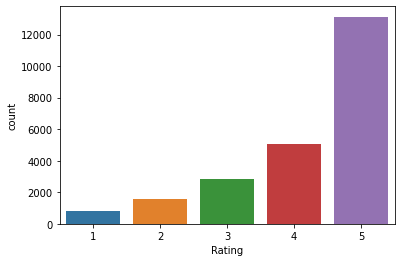

In [ ]:
#visualize number counts of rating
sns.countplot(df['Rating'], data=df)

In [ ]:
#exact counts from Rating Column
df['Rating'].value_counts()

5    13131
4     5077
3     2871
2     1565
1      842
Name: Rating, dtype: int64

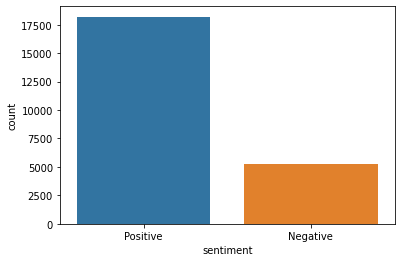

In [ ]:
#target distribution based on sentiment
sns.countplot(df['sentiment'], data=df)

In [ ]:
#exact counts from Rating Column
df['sentiment'].value_counts()

Positive    18208
Negative     5278
Name: sentiment, dtype: int64

# F. Data Pre-Processing

With the amount of data that is not balanced between positive sentiment and negative sentiment, we have to generalize the amount of data in the two target columns.

Therefore the next thing we will do is take a number of samples from each sentiment with an equal number, 5000 samples. This will be done after the data has been preprocessed, namely case folding, stem, and lemma.

In [ ]:
skip = df[['Review Text', 'Rating', 'sentiment']]
skip.dropna(inplace=True)
skip.head()

,Review Text,Rating,sentiment
0,Absolutely wonderful - silky and sexy and comf...,4,Positive
1,Love this dress! it's sooo pretty. i happene...,5,Positive
2,I had such high hopes for this dress and reall...,3,Negative
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Positive
4,This shirt is very flattering to all due to th...,5,Positive


In [ ]:
skip.shape

(22641, 3)

## Text Preprocessing

Text Preprocessing (Case Folding)

In [ ]:
#prepare the function
def remove_digits(string):
    return re.sub(r'\d+', '', string)

def remove_punctuation(text):
    return text.translate(str.maketrans("","", string.punctuation))

def remove_strip(text):
    return text.strip()

#define for stopwords
stop = stopwords.words('english')

In [ ]:
skip['sentiment'] = skip['sentiment'].str.lower() #lowercase
skip['Review Text'] = skip['Review Text'].str.lower() #lowercase
skip['Review Text'] = skip['Review Text'].apply(remove_digits) #remove numbers
skip['Review Text'] = skip['Review Text'].apply(remove_punctuation) #remove punctuation
skip['Review Text'] = skip['Review Text'].apply(remove_strip) #remove whitespaces

skip['Review Text'] = skip['Review Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

Text Preprocessing (Repetitive Words)

source : https://stackoverflow.com/questions/47316783/python-dataframe-remove-duplicate-words-in-the-same-cell-within-a-column-in-pyt

In [ ]:
from collections import OrderedDict
skip['Review Text'] = skip['Review Text'].str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' ')

### Stemming & Lemmatization

In [ ]:
import nltk

ps = nltk.stem.PorterStemmer()
snow = nltk.stem.SnowballStemmer('english')
lm = nltk.wordnet.WordNetLemmatizer()
nltk.download('wordnet')

df_stem1 = skip.copy() #dataset with portar stemmer
df_stem2 = skip.copy() #dataset with snowball stemmer
df_lemma = skip.copy() #dataset with lemma

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#Porter Stemmer Sample Result
df_stem1['Review Text'] = df_stem1['Review Text'].apply(lambda x: " ".join([ps.stem(y) for y in x.split()]))
pd.set_option('display.max_colwidth', -1)
df_stem1.head()

,Review Text,Rating,sentiment
0,absolut wonder silki sexi comfort,4,positive
1,love dress sooo pretti happen find store im glad bc never would order onlin petit bought length hit littl knee definit true midi someon truli,5,positive
2,high hope dress realli want work initi order petit small usual size found outrag fact could zip reorder medium ok overal top half comfort fit nice bottom tight layer sever somewhat cheap net layer imo major design flaw sewn directli zipper c,3,negative
3,love jumpsuit fun flirti fabul everi time wear get noth great compliment,5,positive
4,shirt flatter due adjust front tie perfect length wear leg sleeveless pair well cardigan love,5,positive


In [ ]:
df_stem2['Review Text'] = df_stem2['Review Text'].apply(lambda x: " ".join([snow.stem(y) for y in x.split()]))
pd.set_option('display.max_colwidth', -1)
df_stem2.head()

,Review Text,Rating,sentiment
0,absolut wonder silki sexi comfort,4,positive
1,love dress sooo pretti happen find store im glad bc never would order onlin petit bought length hit littl knee definit true midi someon truli,5,positive
2,high hope dress realli want work initi order petit small usual size found outrag fact could zip reorder medium ok overal top half comfort fit nice bottom tight layer sever somewhat cheap net layer imo major design flaw sewn direct zipper c,3,negative
3,love jumpsuit fun flirti fabul everi time wear get noth great compliment,5,positive
4,shirt flatter due adjust front tie perfect length wear leg sleeveless pair well cardigan love,5,positive


In [ ]:
df_lemma['Review Text'] = df_lemma['Review Text'].apply(lambda x: " ".join([lm.lemmatize(y) for y in x.split()]))
pd.set_option('display.max_colwidth', -1)
df_lemma.head()

,Review Text,Rating,sentiment
0,absolutely wonderful silky sexy comfortable,4,positive
1,love dress sooo pretty happened find store im glad bc never would ordered online petite bought length hit little knee definitely true midi someone truly,5,positive
2,high hope dress really wanted work initially ordered petite small usual size found outrageously fact could zip reordered medium ok overall top half comfortable fit nicely bottom tight layer several somewhat cheap net layer imo major design flaw sewn directly zipper c,3,negative
3,love jumpsuit fun flirty fabulous every time wear get nothing great compliment,5,positive
4,shirt flattering due adjustable front tie perfect length wear legging sleeveless pair well cardigan love,5,positive


From the results obtained above, we decided to only follow up on two datasets, the stemmed and the dilemmatized.

In [ ]:
#change label value
df_lemma['sentiment'] = df_lemma['sentiment'].replace({'negative':  0, 'positive': 1})
df_stem2['sentiment'] = df_stem2['sentiment'].replace({'negative':  0, 'positive': 1})

## Pre-Processing

`skip = dataset without stem & lemma`

`df_stem = dataset with stem`

`df_lemma = dataset with lemma`

`df_both1 = dataset with stem & lemma`

### Under Sampling to Equalize Dataset

AxesSubplot(0.125,0.125;0.775x0.755)
positive    17448
negative    5193 
Name: sentiment, dtype: int64


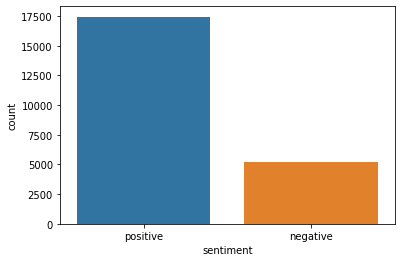

In [ ]:
#target distribution based on sentiment
print(sns.countplot(skip['sentiment'], data=skip))
print(skip['sentiment'].value_counts())

Balanced Data with Stem

In [ ]:
#dataset with balanced amount of target label using sample
s0 = df_stem2.sentiment[df_stem2.sentiment.eq(0)].sample(5000).index
s1 = df_stem2.sentiment[df_stem2.sentiment.eq(1)].sample(5000).index 

balanced_stem = df_stem2.loc[s0.union(s1)].reset_index()
print(balanced_stem.shape)
balanced_stem.head()

(10000, 4)


,index,Review Text,Rating,sentiment
0,2,high hope dress realli want work initi order petit small usual size found outrag fact could zip reorder medium ok overal top half comfort fit nice bottom tight layer sever somewhat cheap net layer imo major design flaw sewn direct zipper c,3,0
1,5,love traci rees dress one petit feet tall usual wear p brand dress pretti packag lot skirt long full overwhelm small frame stranger alter shorten narrow would take away embellish garment color idea style work return,2,0
2,9,im lbs order petit make sure length wasnt long typic wear xs regular retail dress your less busti b cup smaller fit perfect snug tight love could dress parti work tull longer fabric underneath,5,1
3,10,dress run small esp zipper area order sp typic fit tight materi top look feel cheap even pull caus rip fabric pretti disappoint go christma year needless say back,3,0
4,16,materi color nice leg open larg length hit right ankl size waist hem line front pleat make fluffi think imagin flatter look least averag height taller may good,3,0


In [ ]:
#balanced_stem.to_csv('balanced_stem.csv')

In [ ]:
balanced_stem = pd.read_csv('/content/balanced_stem.csv')
balanced_stem.head()

,Unnamed: 0,index,Review Text,Rating,sentiment
0,0,2,high hope dress realli want work initi order p...,3,0
1,1,4,shirt flatter due adjust front tie perfect len...,5,1
2,2,5,love traci rees dress one petit feet tall usua...,2,0
3,3,8,love dress usual get xs run littl snug bust or...,5,1
4,4,10,dress run small esp zipper area order sp typic...,3,0


Balanced Data with Lemma

In [ ]:
#dataset with balanced amount of target label using sample
s0 = df_lemma.sentiment[df_lemma.sentiment.eq(0)].sample(5000).index
s1 = df_lemma.sentiment[df_lemma.sentiment.eq(1)].sample(5000).index 

balanced_lemma = df_lemma.loc[s0.union(s1)].reset_index()
print(balanced_lemma.shape)
balanced_lemma.head()

In [ ]:
#balanced_lemma.to_csv('balanced_lemma.csv')

In [ ]:
balanced_lemma = pd.read_csv('/content/balanced_lemma.csv')
balanced_lemma.head()

,Unnamed: 0,index,Review Text,Rating,sentiment
0,0,2,high hope dress really wanted work initially o...,3,0
1,1,3,love jumpsuit fun flirty fabulous every time w...,5,1
2,2,5,love tracy reese dress one petite foot tall us...,2,0
3,3,6,aded basket hte last mintue see would look lik...,5,1
4,4,10,dress run small esp zipper area ordered sp typ...,3,0


### Dataset Split

In [ ]:
#split data for balanced_stem data with lemma
X_balanced_stem = balanced_stem['Review Text']
y_balanced_stem = balanced_stem['sentiment']

#first split into X_train and X_remaining 75:25
X_train_balance_stem, X_rem_balance_stem, y_train_balance_stem, y_rem_balance_stem = train_test_split(X_balanced_stem, y_balanced_stem, train_size=0.75, random_state=17)

#second split. from X_remain to X_val+X_test
X_val_balance_stem, X_test_balance_stem, y_val_balance_stem, y_test_balance_stem = train_test_split(X_rem_balance_stem, y_rem_balance_stem, test_size=0.5, random_state=17)

In [ ]:
#split data for balanced data with lemma
X_balanced_lemma = balanced_lemma['Review Text']
y_balanced_lemma = balanced_lemma['sentiment']

#first split into X_train and X_remaining 75:25
X_train_balance_lemma, X_rem_balance_lemma, y_train_balance_lemma, y_rem_balance_lemma = train_test_split(X_balanced_lemma, y_balanced_lemma, train_size=0.75, random_state=17)

#second split. from X_remain to X_val+X_test
X_val_balance_lemma, X_test_balance_lemma, y_val_balance_lemma, y_test_balance_lemma = train_test_split(X_rem_balance_lemma, y_rem_balance_lemma, test_size=0.5, random_state=17)

### Token Layer & Embed Layer

In [ ]:
#numbers for max_length
num_length = round(sum([len(i.split()) for i in X_train_balance_stem])/len(X_train_balance_stem))
num_length

27

In [ ]:
#numbers for max_length
num_length = round(sum([len(i.split()) for i in X_train_balance_lemma])/len(X_train_balance_lemma))
num_length

27

In [ ]:
# setup text vect
#if we set max vocab to 100.000, max amount number of vocab will be 15574, so we'll be set only at 10000 vocab
max_vocab_length = 10000
max_length = num_length

text_vectorization = TextVectorization(max_tokens=max_vocab_length,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode='int',
                                       output_sequence_length=max_length)

In [ ]:
output_dim = 64

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=output_dim,
                             embeddings_initializer="uniform",
                             input_length=max_length,
                             mask_zero=True)

# G. Modelling

In [ ]:
#initializer
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.5)

#optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

#callback
my_callback = [
               EarlyStopping(patience=10, monitor='val_loss'),
               ReduceLROnPlateau(patience=3, min_lr=0.000001, monitor='val_loss')]

### Model 1 : Base Model with Balanced Data & Stemmed Only

In [ ]:
text_vectorization.adapt(X_train_balance_stem)

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
text_vectorization.adapt(X_train_balance_stem)

In [ ]:
#definition
inputs = Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dense(32, activation='selu', kernel_initializer=initializer)(x)
x = Dense(8, activation='selu', kernel_initializer=initializer)(x)
output = Dense(1, activation="sigmoid", kernel_initializer=initializer)(x)
model1 = tf.keras.Model(inputs, output, name="model_1")

#compile
model1.compile(loss='binary_crossentropy', 
                   optimizer=opt,
                   metrics='Accuracy')

#base model architecture
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 27)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 27, 64)            640000    
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 8)                 264 

In [ ]:
model1_history = model1.fit(X_train_balance_stem, y_train_balance_stem, epochs=30, 
                                validation_data=(X_val_balance_stem, y_val_balance_stem),
                                callbacks=my_callback)

Epoch 1/30
235/235 [==============================] - 3s 7ms/step - loss: 0.4625 - Accuracy: 0.7923 - val_loss: 0.4098 - val_Accuracy: 0.8144 - lr: 0.0010
Epoch 2/30
235/235 [==============================] - 1s 6ms/step - loss: 0.3185 - Accuracy: 0.8692 - val_loss: 0.4155 - val_Accuracy: 0.8168 - lr: 0.0010
Epoch 3/30
235/235 [==============================] - 1s 6ms/step - loss: 0.2630 - Accuracy: 0.9017 - val_loss: 0.4493 - val_Accuracy: 0.8056 - lr: 0.0010
Epoch 4/30
235/235 [==============================] - 1s 6ms/step - loss: 0.2247 - Accuracy: 0.9153 - val_loss: 0.4978 - val_Accuracy: 0.8016 - lr: 0.0010
Epoch 5/30
235/235 [==============================] - 1s 6ms/step - loss: 0.1639 - Accuracy: 0.9483 - val_loss: 0.5054 - val_Accuracy: 0.8048 - lr: 1.0000e-04
Epoch 6/30
235/235 [==============================] - 1s 6ms/step - loss: 0.1542 - Accuracy: 0.9524 - val_loss: 0.5175 - val_Accuracy: 0.8032 - lr: 1.0000e-04
Epoch 7/30
235/235 [==============================] - 1s 6ms/s

### Model 2 : Base Model with Balanced Data & Lemmatized Only

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
text_vectorization.adapt(X_train_balance_lemma)

In [ ]:
#definition
inputs = Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dense(32, activation='selu', kernel_initializer=initializer)(x)
x = Dense(8, activation='selu', kernel_initializer=initializer)(x)
output = Dense(1, activation="sigmoid", kernel_initializer=initializer)(x)
model2 = tf.keras.Model(inputs, output, name="model_2")

#compile
model2.compile(loss='binary_crossentropy', 
                   optimizer=opt,
                   metrics='Accuracy')

#base model architecture
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 27)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 27, 64)            640000    
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 8)                 264 

In [ ]:
%%time
model2_history = model2.fit(X_train_balance_lemma, y_train_balance_lemma, epochs=30,
                            validation_data=(X_val_balance_lemma, y_val_balance_lemma),
                            callbacks=my_callback)

Epoch 1/30
235/235 [==============================] - 3s 7ms/step - loss: 0.1421 - Accuracy: 0.9524 - val_loss: 0.5969 - val_Accuracy: 0.8048 - lr: 0.0010
Epoch 2/30
235/235 [==============================] - 2s 6ms/step - loss: 0.1068 - Accuracy: 0.9651 - val_loss: 0.7032 - val_Accuracy: 0.7768 - lr: 0.0010
Epoch 3/30
235/235 [==============================] - 2s 6ms/step - loss: 0.0819 - Accuracy: 0.9724 - val_loss: 0.8397 - val_Accuracy: 0.7688 - lr: 0.0010
Epoch 4/30
235/235 [==============================] - 2s 6ms/step - loss: 0.0658 - Accuracy: 0.9784 - val_loss: 0.9622 - val_Accuracy: 0.7680 - lr: 0.0010
Epoch 5/30
235/235 [==============================] - 2s 6ms/step - loss: 0.0394 - Accuracy: 0.9903 - val_loss: 0.9679 - val_Accuracy: 0.7696 - lr: 1.0000e-04
Epoch 6/30
235/235 [==============================] - 2s 7ms/step - loss: 0.0353 - Accuracy: 0.9915 - val_loss: 0.9912 - val_Accuracy: 0.7688 - lr: 1.0000e-04
Epoch 7/30
235/235 [==============================] - 1s 6ms/s

# H. Model Evaluation

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  Accuracy = history.history['Accuracy']
  val_Accuracy = history.history['val_Accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, Accuracy, label='training_Accuracy')
  plt.plot(epochs, val_Accuracy, label='val_Accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

### Model 1 : Base Model with Balanced Data & Stemmed Only

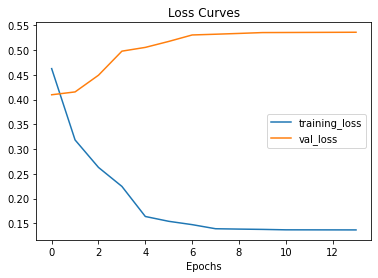

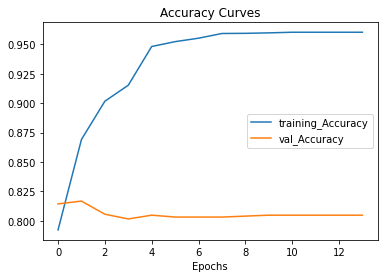

In [ ]:
plot_loss_curves(model1_history)

In [ ]:
#classification report
from sklearn.metrics import classification_report

thre = 0.5
res = model1.predict(X_val_balance_stem)
res = (res > thre).T
res = res.astype(int)[0]

print(classification_report(y_val_balance_stem, res))

              precision    recall  f1-score   support

           0       0.48      0.43      0.46       628
           1       0.48      0.52      0.50       622

    accuracy                           0.48      1250
   macro avg       0.48      0.48      0.48      1250
weighted avg       0.48      0.48      0.48      1250



### Model 2 : Base Model with Balanced Data & Lemmatized Only

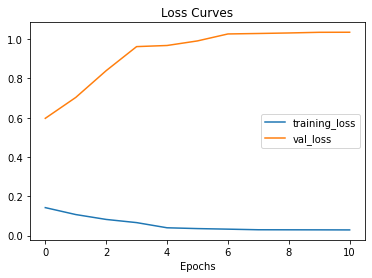

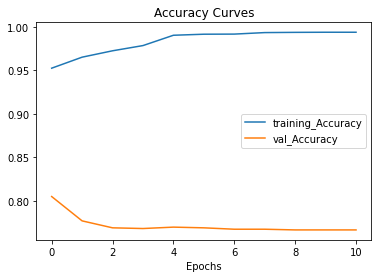

In [ ]:
plot_loss_curves(model2_history)

In [ ]:
#classification report
from sklearn.metrics import classification_report

thre = 0.5
res = model2.predict(X_val_balance_lemma)
res = (res > thre).T
res = res.astype(int)[0]

print(classification_report(y_val_balance_lemma, res))

              precision    recall  f1-score   support

           0       0.78      0.73      0.76       616
           1       0.75      0.80      0.78       634

    accuracy                           0.77      1250
   macro avg       0.77      0.77      0.77      1250
weighted avg       0.77      0.77      0.77      1250



# I. Model Improvement

After doing several researches on initializer search, optimization, and activation function, we come to the conclusion that with the data we have, the best initializer, activation, and optimization is the Random Normal initializer, Selu activation function, with Adam as the optimizer. Then based on matching the model with the dataset above, we can conclude that the best model is the second base model with the training data that has been lemmatized. However, the model has a tendency to overfit because its training was stopped by my_callback

For this reason, at this model improvement stage, we will try to make improvements to the model by experimenting with combinations between one layer and another such as LSTM layer, Bidirectional layer, Spatial Dropout layer, and so on.

In [ ]:
new_metrics=[
             tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
             tf.keras.metrics.Recall(name='recall')]

def newplot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  Accuracy = history.history['Accuracy']
  val_Accuracy = history.history['val_Accuracy']

  recall = history.history['recall']
  val_recall = history.history['val_recall']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, Accuracy, label='training_Accuracy')
  plt.plot(epochs, val_Accuracy, label='val_Accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()


  plt.figure()
  plt.plot(epochs, recall, label='recall')
  plt.plot(epochs, val_recall, label='val_recall')
  plt.title("Recall Curves")
  plt.xlabel("Epochs")
  plt.legend()

### 1. Improvement I Balanced Lemma Data Train with Bidirectional LSTM

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
text_vectorization.adapt(X_train_balance_lemma)

In [ ]:
#definition
inputs = Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D(keepdims=True)(x)
x = SpatialDropout1D(0.4)(x)
x = Bidirectional(LSTM(64, activation='selu', kernel_initializer=initializer, return_sequences=True))(x)
x = SpatialDropout1D(0.5)(x)
x = Dense(32, activation='selu', kernel_initializer=initializer)(x)
x = Dropout(0.2)(x)
x = Dense(8, activation='selu', kernel_initializer=initializer)(x)
output = Dense(1, activation="sigmoid", kernel_initializer=initializer)(x)
model_imp1 = tf.keras.Model(inputs, output, name="model_imp1")

#compile
model_imp1.compile(loss='binary_crossentropy', 
                   optimizer='Adam',
                   metrics=new_metrics)

#base model architecture
model_imp1.summary()

Model: "model_imp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 27)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 27, 64)            640000    
                                                                 
 global_average_pooling1d (G  (None, 1, 64)            0         
 lobalAveragePooling1D)                                          
                                                                 
 spatial_dropout1d (SpatialD  (None, 1, 64)            0         
 ropout1D)                                                       
                                                        

In [ ]:
%%time

model_imp1_history = model_imp1.fit(X_train_balance_lemma, y_train_balance_lemma, epochs=40, 
                                validation_data=(X_val_balance_lemma, y_val_balance_lemma),
                                callbacks=my_callback)

Epoch 1/40
235/235 [==============================] - 8s 17ms/step - loss: 0.5242 - Accuracy: 0.7296 - recall: 0.7237 - val_loss: 0.3631 - val_Accuracy: 0.8512 - val_recall: 0.8360 - lr: 0.0010
Epoch 2/40
235/235 [==============================] - 3s 14ms/step - loss: 0.3553 - Accuracy: 0.8536 - recall: 0.8511 - val_loss: 0.3624 - val_Accuracy: 0.8552 - val_recall: 0.8344 - lr: 0.0010
Epoch 3/40
235/235 [==============================] - 3s 14ms/step - loss: 0.2874 - Accuracy: 0.8887 - recall: 0.8904 - val_loss: 0.3824 - val_Accuracy: 0.8528 - val_recall: 0.8328 - lr: 0.0010
Epoch 4/40
235/235 [==============================] - 3s 14ms/step - loss: 0.2471 - Accuracy: 0.9063 - recall: 0.9036 - val_loss: 0.4221 - val_Accuracy: 0.8336 - val_recall: 0.8297 - lr: 0.0010
Epoch 5/40
235/235 [==============================] - 3s 14ms/step - loss: 0.2113 - Accuracy: 0.9257 - recall: 0.9243 - val_loss: 0.4503 - val_Accuracy: 0.8320 - val_recall: 0.8202 - lr: 0.0010
Epoch 6/40
235/235 [==========

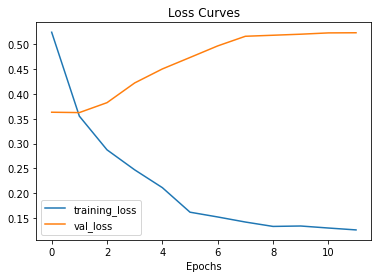

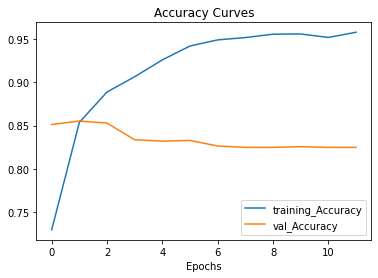

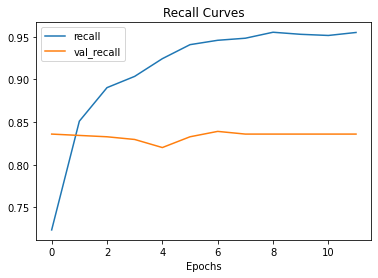

In [ ]:
newplot_loss_curves(model_imp1_history)

In [ ]:
# Evaluate the model on the validation data using evaluate
print("Evaluate on validation data")
results = model_imp1.evaluate(X_val_balance_lemma, y_val_balance_lemma, batch_size=128)
print("validation loss, validation acc, validation recall:", results)
print('\n')
# Evaluate the model on the test data using evaluate
print("Evaluate on test data")
results = model_imp1.evaluate(X_test_balance_lemma, y_test_balance_lemma, batch_size=128)
print("test loss, test acc, test recall:", results)

Evaluate on validation data
10/10 [==============================] - 0s 5ms/step - loss: 0.5232 - Accuracy: 0.8248 - recall: 0.8360
validation loss, validation acc, validation recall: [0.5231698751449585, 0.8248000144958496, 0.8359621167182922]


Evaluate on test data
10/10 [==============================] - 0s 5ms/step - loss: 0.5321 - Accuracy: 0.8136 - recall: 0.8086
test loss, test acc, test recall: [0.5320554971694946, 0.8136000037193298, 0.8085758090019226]


In [ ]:
#classification report
from sklearn.metrics import classification_report, f1_score

thre = 0.5
res = model_imp1.predict(X_val_balance_lemma)
res = (res > thre).T
res = res.astype(int)[0]

print(classification_report(y_val_balance_lemma.tolist(), list(res[0])))
print(f1_score(y_val_balance_lemma.tolist(), list(res[0])))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       616
           1       0.82      0.84      0.83       634

    accuracy                           0.82      1250
   macro avg       0.82      0.82      0.82      1250
weighted avg       0.82      0.82      0.82      1250

0.8287724784988273


In [ ]:
thre = 0.5
res = model_imp1.predict(X_test_balance_lemma)
res = (res > thre).T
res = res.astype(int)[0]

print(classification_report(y_test_balance_lemma.tolist(), list(res[0])))
print(f1_score(y_test_balance_lemma.tolist(), list(res[0])))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       597
           1       0.83      0.81      0.82       653

    accuracy                           0.81      1250
   macro avg       0.81      0.81      0.81      1250
weighted avg       0.81      0.81      0.81      1250

0.8192397207137315


### 2. Improvement II Balanced Lemma Data Train with Double Stacked Bidirectional LSTM

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#definition
inputs = Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D(keepdims=True)(x)
x = SpatialDropout1D(0.4)(x)
x = Bidirectional(LSTM(64, activation='selu', kernel_initializer=initializer, return_sequences=True))(x)
x = Bidirectional(LSTM(32, activation='selu', kernel_initializer=initializer, return_sequences=True))(x)
x = SpatialDropout1D(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32, activation='selu', kernel_initializer=initializer)(x)
x = Dropout(0.2)(x)
x = Dense(8, activation='selu', kernel_initializer=initializer)(x)
output = Dense(1, activation="sigmoid", kernel_initializer=initializer)(x)
model_imp2 = tf.keras.Model(inputs, output, name="model_imp2")

#compile
model_imp2.compile(loss='binary_crossentropy', 
                   optimizer='Adam',
                   metrics=new_metrics)

#base model architecture
model_imp2.summary()

Model: "model_imp2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 27)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 27, 64)            640000    
                                                                 
 global_average_pooling1d (G  (None, 1, 64)            0         
 lobalAveragePooling1D)                                          
                                                                 
 spatial_dropout1d (SpatialD  (None, 1, 64)            0         
 ropout1D)                                                       
                                                        

In [ ]:
%%time

model_imp2_history = model_imp2.fit(X_train_balance_lemma, y_train_balance_lemma, epochs=40, 
                                validation_data=(X_val_balance_lemma, y_val_balance_lemma),
                                callbacks=my_callback)

Epoch 1/40
235/235 [==============================] - 11s 20ms/step - loss: 0.4470 - Accuracy: 0.8513 - recall: 0.8525 - val_loss: 0.5312 - val_Accuracy: 0.8288 - val_recall: 0.8139 - lr: 0.0010
Epoch 2/40
235/235 [==============================] - 4s 16ms/step - loss: 0.2113 - Accuracy: 0.9328 - recall: 0.9313 - val_loss: 0.7766 - val_Accuracy: 0.8152 - val_recall: 0.7981 - lr: 0.0010
Epoch 3/40
235/235 [==============================] - 4s 17ms/step - loss: 0.1740 - Accuracy: 0.9388 - recall: 0.9316 - val_loss: 0.7789 - val_Accuracy: 0.8064 - val_recall: 0.7871 - lr: 0.0010
Epoch 4/40
235/235 [==============================] - 4s 16ms/step - loss: 0.1455 - Accuracy: 0.9493 - recall: 0.9413 - val_loss: 0.8387 - val_Accuracy: 0.8000 - val_recall: 0.7839 - lr: 0.0010
Epoch 5/40
235/235 [==============================] - 4s 17ms/step - loss: 0.1280 - Accuracy: 0.9549 - recall: 0.9432 - val_loss: 0.8478 - val_Accuracy: 0.8040 - val_recall: 0.7823 - lr: 1.0000e-04
Epoch 6/40
235/235 [=====

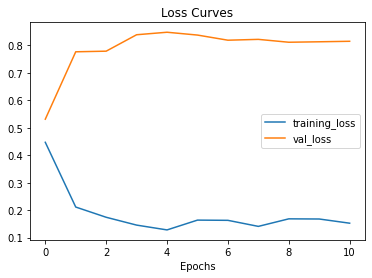

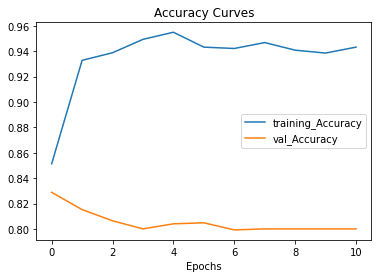

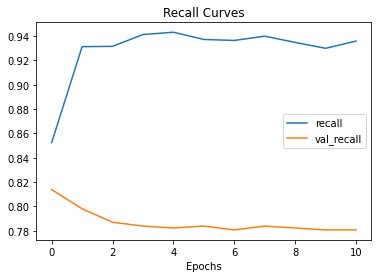

In [ ]:
newplot_loss_curves(model_imp2_history)

In [ ]:
# Evaluate the model on the validation data using evaluate
print("Evaluate on validation data")
results = model_imp2.evaluate(X_val_balance_lemma, y_val_balance_lemma, batch_size=128)
print("validation loss, validation acc, validation recall:", results)
print('\n')
# Evaluate the model on the test data using evaluate
print("Evaluate on test data")
results = model_imp2.evaluate(X_test_balance_lemma, y_test_balance_lemma, batch_size=128)
print("test loss, test acc, test recall:", results)

Evaluate on validation data
10/10 [==============================] - 0s 6ms/step - loss: 0.8149 - Accuracy: 0.8000 - recall: 0.7808
validation loss, validation acc, validation recall: [0.8148890733718872, 0.800000011920929, 0.7807570695877075]


Evaluate on test data
10/10 [==============================] - 0s 7ms/step - loss: 0.8157 - Accuracy: 0.7976 - recall: 0.7642
test loss, test acc, test recall: [0.8156641125679016, 0.7975999712944031, 0.7641654014587402]


In [ ]:
#classification report
from sklearn.metrics import classification_report, f1_score

thre = 0.5
res = model_imp2.predict(X_val_balance_lemma)
res = (res > thre).T
res = res.astype(int)[0]

print(classification_report(y_val_balance_lemma.tolist(), list(res[0])))
print(f1_score(y_val_balance_lemma.tolist(), list(res[0])))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       616
           1       0.82      0.78      0.80       634

    accuracy                           0.80      1250
   macro avg       0.80      0.80      0.80      1250
weighted avg       0.80      0.80      0.80      1250

0.7983870967741936


In [ ]:
#classification report
from sklearn.metrics import classification_report, f1_score

thre = 0.5
res = model_imp2.predict(X_test_balance_lemma)
res = (res > thre).T
res = res.astype(int)[0]

print(classification_report(y_test_balance_lemma.tolist(), list(res[0])))
print(f1_score(y_test_balance_lemma.tolist(), list(res[0])))

              precision    recall  f1-score   support

           0       0.76      0.83      0.80       597
           1       0.83      0.76      0.80       653

    accuracy                           0.80      1250
   macro avg       0.80      0.80      0.80      1250
weighted avg       0.80      0.80      0.80      1250

0.7977617905675459


### 3. Improvement III Balanced Lemma Data Train with LSTM + 3 Bidirectional + BatchNorm

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#definition
inputs = Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D(keepdims=True)(x)
x = LSTM(128, activation='selu', kernel_initializer=initializer, return_sequences=True)(x)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(128, activation='selu', kernel_initializer=initializer, return_sequences=True))(x)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(256, activation='selu', kernel_initializer=initializer, return_sequences=True))(x)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(128, activation='selu', kernel_initializer=initializer, return_sequences=True))(x)
x = SpatialDropout1D(0.2)(x)
x = Dense(128, activation='selu', kernel_initializer=initializer)(x)
x = SpatialDropout1D(0.2)(x)
x = Dense(32, activation='selu', kernel_initializer=initializer)(x)
x = Dense(8, activation='selu', kernel_initializer=initializer)(x)
output = Dense(1, activation="sigmoid", kernel_initializer=initializer)(x)
model_imp3 = tf.keras.Model(inputs, output, name="model_imp3")

#compile
model_imp3.compile(loss='binary_crossentropy', 
                   optimizer='Adam',
                   metrics=new_metrics)

#base model architecture
model_imp3.summary()

Model: "model_imp3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 27)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 27, 64)            640000    
                                                                 
 global_average_pooling1d (G  (None, 1, 64)            0         
 lobalAveragePooling1D)                                          
                                                                 
 lstm (LSTM)                 (None, 1, 128)            98816     
                                                                 
 spatial_dropout1d (SpatialD  (None, 1, 128)           0

In [ ]:
%%time

model_imp3_history = model_imp3.fit(X_train_balance_lemma, y_train_balance_lemma, epochs=40, 
                                validation_data=(X_val_balance_lemma, y_val_balance_lemma),
                                callbacks=my_callback)

Epoch 1/40
235/235 [==============================] - 22s 52ms/step - loss: 6.2624 - Accuracy: 0.5963 - recall: 0.8694 - val_loss: 3.2379 - val_Accuracy: 0.7368 - val_recall: 0.5410 - lr: 0.0010
Epoch 2/40
235/235 [==============================] - 11s 46ms/step - loss: 1.6813 - Accuracy: 0.7577 - recall: 0.7081 - val_loss: 1.2382 - val_Accuracy: 0.7224 - val_recall: 0.5016 - lr: 0.0010
Epoch 3/40
235/235 [==============================] - 11s 46ms/step - loss: 0.6650 - Accuracy: 0.7895 - recall: 0.7336 - val_loss: 0.6815 - val_Accuracy: 0.7984 - val_recall: 0.7082 - lr: 0.0010
Epoch 4/40
235/235 [==============================] - 11s 46ms/step - loss: 0.4177 - Accuracy: 0.8465 - recall: 0.8163 - val_loss: 0.6217 - val_Accuracy: 0.7992 - val_recall: 0.7334 - lr: 0.0010
Epoch 5/40
235/235 [==============================] - 11s 46ms/step - loss: 0.3264 - Accuracy: 0.8896 - recall: 0.8705 - val_loss: 0.6229 - val_Accuracy: 0.8032 - val_recall: 0.7571 - lr: 0.0010
Epoch 6/40
235/235 [=====

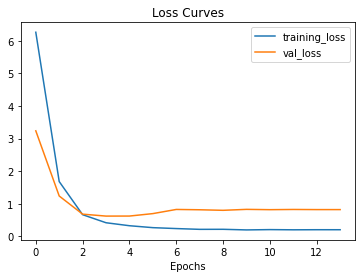

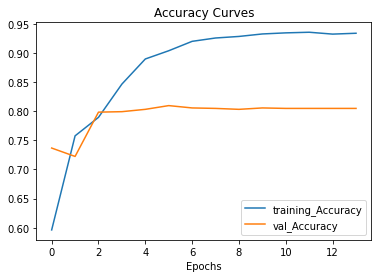

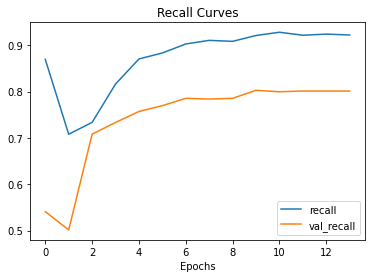

In [ ]:
newplot_loss_curves(model_imp3_history)

In [ ]:
# Evaluate the model on the validation data using evaluate
print("Evaluate on validation data")
results = model_imp3.evaluate(X_val_balance_lemma, y_val_balance_lemma, batch_size=128)
print("validation loss, validation acc, validation recall:", results)
print('\n')
# Evaluate the model on the test data using evaluate
print("Evaluate on test data")
results = model_imp3.evaluate(X_test_balance_lemma, y_test_balance_lemma, batch_size=128)
print("test loss, test acc, test recall:", results)

Evaluate on validation data
10/10 [==============================] - 0s 34ms/step - loss: 0.8210 - Accuracy: 0.8048 - recall: 0.8013
validation loss, validation acc, validation recall: [0.8209852576255798, 0.8047999739646912, 0.801261842250824]


Evaluate on test data
10/10 [==============================] - 0s 30ms/step - loss: 0.7973 - Accuracy: 0.7952 - recall: 0.7672
test loss, test acc, test recall: [0.7972962260246277, 0.795199990272522, 0.7672281861305237]


In [ ]:
#classification report
from sklearn.metrics import classification_report, f1_score

thre = 0.5
res = model_imp3.predict(X_val_balance_lemma)
res = (res > thre).T
res = res.astype(int)[0]

print(classification_report(y_val_balance_lemma.tolist(), list(res[0])))
print(f1_score(y_val_balance_lemma.tolist(), list(res[0])))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80       616
           1       0.81      0.80      0.81       634

    accuracy                           0.80      1250
   macro avg       0.80      0.80      0.80      1250
weighted avg       0.80      0.80      0.80      1250

0.8063492063492064


In [ ]:
#classification report
from sklearn.metrics import classification_report, f1_score

thre = 0.5
res = model_imp3.predict(X_test_balance_lemma)
res = (res > thre).T
res = res.astype(int)[0]

print(classification_report(y_test_balance_lemma.tolist(), list(res[0])))
print(f1_score(y_test_balance_lemma.tolist(), list(res[0])))

              precision    recall  f1-score   support

           0       0.76      0.83      0.79       597
           1       0.83      0.77      0.80       653

    accuracy                           0.80      1250
   macro avg       0.80      0.80      0.80      1250
weighted avg       0.80      0.80      0.80      1250

0.7965023847376789


### 4. Improvement IV Balanced Lemma Data Train with LSTM + 2 Bidirectional + LSTM + Spatial Dropout

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#definition
inputs = Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D(keepdims=True)(x)
x = LSTM(128, activation='selu', kernel_initializer=initializer, return_sequences=True)(x)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(128, activation='selu', kernel_initializer=initializer, return_sequences=True))(x)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(128, activation='selu', kernel_initializer=initializer, return_sequences=True))(x)
x = SpatialDropout1D(0.2)(x)
x = LSTM(128, activation='selu', kernel_initializer=initializer, return_sequences=True)(x)
x = SpatialDropout1D(0.5)(x)
x = Dense(64, activation='selu', kernel_initializer=initializer)(x)
x = Dense(8, activation='selu', kernel_initializer=initializer)(x)
output = Dense(1, activation="sigmoid", kernel_initializer=initializer)(x)
model_imp4 = tf.keras.Model(inputs, output, name="model_imp4")

#compile
model_imp4.compile(loss='binary_crossentropy', 
                   optimizer='Adam',
                   metrics=new_metrics)

#base model architecture
model_imp4.summary()

Model: "model_imp4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 27)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 27, 64)            640000    
                                                                 
 global_average_pooling1d (G  (None, 1, 64)            0         
 lobalAveragePooling1D)                                          
                                                                 
 lstm (LSTM)                 (None, 1, 128)            98816     
                                                                 
 spatial_dropout1d (SpatialD  (None, 1, 128)           0

In [ ]:
%%time

model_imp4_history = model_imp4.fit(X_train_balance_lemma, y_train_balance_lemma, epochs=50, 
                                validation_data=(X_val_balance_lemma, y_val_balance_lemma),
                                callbacks=my_callback)

Epoch 1/50
235/235 [==============================] - 31s 63ms/step - loss: 1.7147 - Accuracy: 0.8176 - recall: 0.7994 - val_loss: 2.1713 - val_Accuracy: 0.8080 - val_recall: 0.8691 - lr: 0.0010
Epoch 2/50
235/235 [==============================] - 12s 53ms/step - loss: 0.7327 - Accuracy: 0.9188 - recall: 0.9235 - val_loss: 1.5716 - val_Accuracy: 0.7984 - val_recall: 0.8644 - lr: 0.0010
Epoch 3/50
235/235 [==============================] - 12s 53ms/step - loss: 0.5018 - Accuracy: 0.9265 - recall: 0.9378 - val_loss: 1.3327 - val_Accuracy: 0.7960 - val_recall: 0.8596 - lr: 0.0010
Epoch 4/50
235/235 [==============================] - 11s 47ms/step - loss: 0.4053 - Accuracy: 0.9228 - recall: 0.9461 - val_loss: 1.1114 - val_Accuracy: 0.7792 - val_recall: 0.8959 - lr: 0.0010
Epoch 5/50
235/235 [==============================] - 12s 53ms/step - loss: 0.3405 - Accuracy: 0.9351 - recall: 0.9631 - val_loss: 1.0259 - val_Accuracy: 0.7744 - val_recall: 0.8991 - lr: 0.0010
Epoch 6/50
235/235 [=====

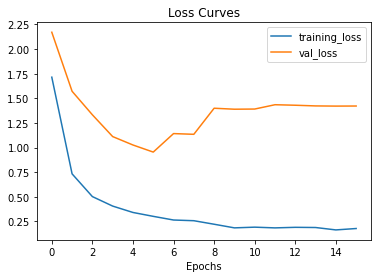

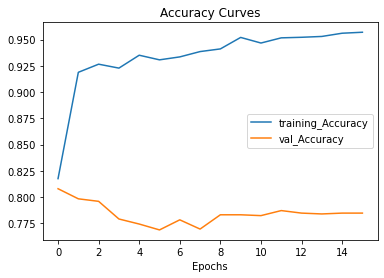

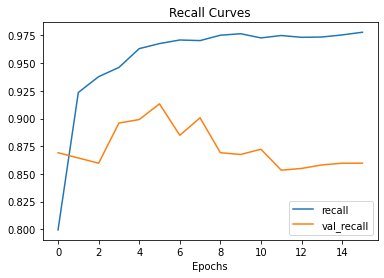

In [ ]:
newplot_loss_curves(model_imp4_history)

In [ ]:
# Evaluate the model on the validation data using evaluate
print("Evaluate on validation data")
results = model_imp4.evaluate(X_val_balance_lemma, y_val_balance_lemma)
print("validation loss, validation acc, validation recall:", results)
print('\n')
# Evaluate the model on the test data using evaluate
print("Evaluate on test data")
results = model_imp4.evaluate(X_test_balance_lemma, y_test_balance_lemma)
print("test loss, test acc, test recall:", results)

Evaluate on validation data
40/40 [==============================] - 0s 7ms/step - loss: 1.4218 - Accuracy: 0.7848 - recall: 0.8596
validation loss, validation acc, validation recall: [1.421804428100586, 0.7847999930381775, 0.8596214652061462]


Evaluate on test data
40/40 [==============================] - 0s 7ms/step - loss: 1.4499 - Accuracy: 0.7888 - recall: 0.8377
test loss, test acc, test recall: [1.4499033689498901, 0.7888000011444092, 0.8376722931861877]


In [ ]:
#classification report
from sklearn.metrics import classification_report, f1_score

thre = 0.5
res = model_imp4.predict(X_val_balance_lemma)
res = (res > thre).T
res = res.astype(int)[0]

print(classification_report(y_val_balance_lemma.tolist(), list(res[0])))
print(f1_score(y_val_balance_lemma.tolist(), list(res[0])))

              precision    recall  f1-score   support

           0       0.83      0.71      0.76       616
           1       0.75      0.86      0.80       634

    accuracy                           0.78      1250
   macro avg       0.79      0.78      0.78      1250
weighted avg       0.79      0.78      0.78      1250

0.8020603384841795


In [ ]:
thre = 0.5
res = model_imp4.predict(X_test_balance_lemma)
res = (res > thre).T
res = res.astype(int)[0]

print(classification_report(y_test_balance_lemma.tolist(), list(res[0])))
print(f1_score(y_test_balance_lemma.tolist(), list(res[0])))

              precision    recall  f1-score   support

           0       0.81      0.74      0.77       597
           1       0.78      0.84      0.81       653

    accuracy                           0.79      1250
   macro avg       0.79      0.79      0.79      1250
weighted avg       0.79      0.79      0.79      1250

0.8055964653902798


### 5. Model Improvement V Balanced Lemma Data Train with LSTM + 2 Bidirectional + LSTM 

In [ ]:
#tf.keras.backend.clear_session()
#np.random.seed(42)
#tf.random.set_seed(42)

In [ ]:
#definition
inputs = Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D(keepdims=True)(x)
x = LSTM(128, activation='selu', kernel_initializer=initializer, return_sequences=True)(x)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(128, activation='selu', kernel_initializer=initializer, return_sequences=True))(x)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(128, activation='selu', kernel_initializer=initializer, return_sequences=True))(x)
x = SpatialDropout1D(0.2)(x)
x = LSTM(128, activation='selu', kernel_initializer=initializer, return_sequences=True)(x)
x = SpatialDropout1D(0.5)(x)
output = Dense(1, activation="sigmoid", kernel_initializer=initializer)(x)
model_imp5 = tf.keras.Model(inputs, output, name="model_imp5")

#compile
model_imp5.compile(loss='binary_crossentropy', 
                   optimizer='Adam',
                   metrics=new_metrics)

#base model architecture
model_imp5.summary()

Model: "model_imp5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 27)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 27, 64)            640000    
                                                                 
 global_average_pooling1d_1   (None, 1, 64)            0         
 (GlobalAveragePooling1D)                                        
                                                                 
 lstm_4 (LSTM)               (None, 1, 128)            98816     
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 1, 128)           0

In [ ]:
%%time

model_imp5_history = model_imp5.fit(X_train_balance_lemma, y_train_balance_lemma, epochs=50, 
                                validation_data=(X_val_balance_lemma, y_val_balance_lemma),
                                callbacks=my_callback)

Epoch 1/50
235/235 [==============================] - 18s 40ms/step - loss: 0.6827 - Accuracy: 0.8458 - recall: 0.8436 - val_loss: 1.5900 - val_Accuracy: 0.7984 - val_recall: 0.8312 - lr: 0.0010
Epoch 2/50
235/235 [==============================] - 7s 29ms/step - loss: 0.2961 - Accuracy: 0.9352 - recall: 0.9364 - val_loss: 1.6708 - val_Accuracy: 0.7960 - val_recall: 0.8139 - lr: 0.0010
Epoch 3/50
235/235 [==============================] - 8s 35ms/step - loss: 0.2284 - Accuracy: 0.9483 - recall: 0.9464 - val_loss: 1.5403 - val_Accuracy: 0.7816 - val_recall: 0.8312 - lr: 0.0010
Epoch 4/50
235/235 [==============================] - 7s 29ms/step - loss: 0.1829 - Accuracy: 0.9543 - recall: 0.9539 - val_loss: 1.4720 - val_Accuracy: 0.7928 - val_recall: 0.8312 - lr: 0.0010
Epoch 5/50
235/235 [==============================] - 7s 29ms/step - loss: 0.1434 - Accuracy: 0.9612 - recall: 0.9639 - val_loss: 1.4694 - val_Accuracy: 0.7864 - val_recall: 0.8186 - lr: 0.0010
Epoch 6/50
235/235 [=========

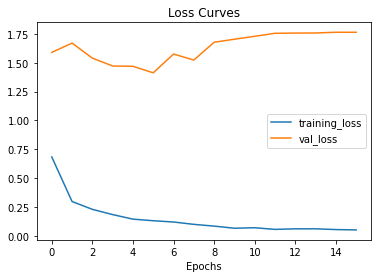

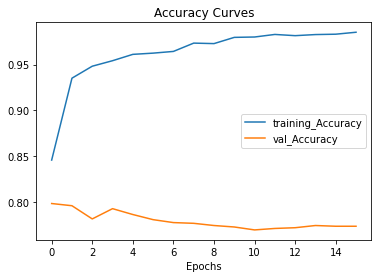

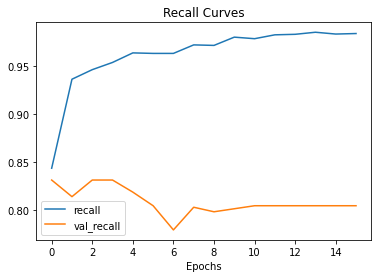

In [ ]:
newplot_loss_curves(model_imp5_history)

In [ ]:
# Evaluate the model on the validation data using evaluate
print("Evaluate on validation data")
results = model_imp5.evaluate(X_val_balance_lemma, y_val_balance_lemma)
print("validation loss, validation acc, validation recall:", results)
print('\n')
# Evaluate the model on the test data using evaluate
print("Evaluate on test data")
results = model_imp5.evaluate(X_test_balance_lemma, y_test_balance_lemma)
print("test loss, test acc, test recall:", results)

Evaluate on validation data
40/40 [==============================] - 0s 7ms/step - loss: 1.7647 - Accuracy: 0.7736 - recall: 0.8044
validation loss, validation acc, validation recall: [1.7646552324295044, 0.7735999822616577, 0.8044164180755615]


Evaluate on test data
40/40 [==============================] - 0s 7ms/step - loss: 1.7413 - Accuracy: 0.7848 - recall: 0.8055
test loss, test acc, test recall: [1.7412824630737305, 0.7847999930381775, 0.8055130243301392]


In [ ]:
#classification report
from sklearn.metrics import classification_report, f1_score

thre = 0.5
res = model_imp5.predict(X_val_balance_lemma)
res = (res > thre).T
res = res.astype(int)[0]

print(classification_report(y_val_balance_lemma.tolist(), list(res[0])))
print(f1_score(y_val_balance_lemma.tolist(), list(res[0])))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76       616
           1       0.76      0.80      0.78       634

    accuracy                           0.77      1250
   macro avg       0.77      0.77      0.77      1250
weighted avg       0.77      0.77      0.77      1250

0.7828089025326171


In [ ]:
thre = 0.5
res = model_imp5.predict(X_test_balance_lemma)
res = (res > thre).T
res = res.astype(int)[0]

print(classification_report(y_test_balance_lemma.tolist(), list(res[0])))
print(f1_score(y_test_balance_lemma.tolist(), list(res[0])))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       597
           1       0.79      0.81      0.80       653

    accuracy                           0.78      1250
   macro avg       0.78      0.78      0.78      1250
weighted avg       0.78      0.78      0.78      1250

0.7963663890991672


# J. Model Saving

### Save Model Improvement 1

In [ ]:
#save best model
!mkdir my_model
model_imp1.save('/content/my_model')

INFO:tensorflow:Assets written to: /content/my_model/assets


In [ ]:
from google.colab import files

!zip -r /content/my_model /content/my_model

files.download("/content/my_model.zip")

  adding: content/my_model/ (stored 0%)
  adding: content/my_model/saved_model.pb (deflated 86%)
  adding: content/my_model/variables/ (stored 0%)
  adding: content/my_model/variables/variables.index (deflated 67%)
  adding: content/my_model/variables/variables.data-00000-of-00001 (deflated 21%)
  adding: content/my_model/assets/ (stored 0%)
  adding: content/my_model/keras_metadata.pb (deflated 90%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Save Model Improvement 3

In [ ]:
import os
model_version = "0001"
model_name = "my_model_3"
model_path = os.path.join(model_name, model_version)
model_path

'my_model_3/0001'

In [ ]:
tf.saved_model.save(model_imp3, model_path)

INFO:tensorflow:Assets written to: my_model_3/0001/assets


INFO:tensorflow:Assets written to: my_model_3/0001/assets


In [ ]:
!zip -r /content/my_model_3 /content/my_model_3

files.download("/content/my_model_3.zip")

  adding: content/my_model_3/ (stored 0%)
  adding: content/my_model_3/0001/ (stored 0%)
  adding: content/my_model_3/0001/saved_model.pb (deflated 89%)
  adding: content/my_model_3/0001/variables/ (stored 0%)
  adding: content/my_model_3/0001/variables/variables.index (deflated 73%)
  adding: content/my_model_3/0001/variables/variables.data-00000-of-00001 (deflated 36%)
  adding: content/my_model_3/0001/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# K. Model Inference

In [ ]:
model_1 = tf.keras.models.load_model('/content/my_model')

In [ ]:
new_text = ["I am really hate this dress"]

thre = 0.5
pred = model_1.predict(new_text)
pred = (pred > thre).T
pred = pred.astype(int)[0]
pred.argmax(axis=1)
pred

array([[0]])

# L. Conclusion

1. The data we have is imbalance data. This is the reason why we decided to only classify two sentiments, positive and negative, rather than positive, neutral, and negative.
2. The preprocessing steps we perform include lowercase, removing stop words, removing punctuation, removing duplicate words, using snowball stemmer also lemmatization, and using text vectorization and embedding layers from TensorFlow.
3. After several trials and errors, we have come to the conclusion that the best deep learning model is achieved by using balanced data that has been lemmatized. On the other hand, at the same stage, we also search for kernel_initializer, activation function, and optimizer which then results in the conclusion that the best kernel is random normal, always activation function, and Adam/RMSprop optimizer.
4. Regarding the results of the best model architecture to predict the sentiment value, we get it in the next stage of the experiment. Our further experiments start from the basic model architecture, LSTM architecture, and Bidirectional LSTM architecture. However, with the amount of data that tends to be small, the optimal Deep Learning model that we create is found in the base model architecture.